In [1]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os

# Robust path finding for data.mat
current_path = Path.cwd()
possible_data_paths = [
    current_path / 'data' / 'data.mat',
    current_path.parent / 'data' / 'data.mat',
    current_path.parent.parent / 'data' / 'data.mat',
    # Fallback absolute path
    Path('/home/luky/skola/KalmanNet-for-state-estimation/data/data.mat')
]

dataset_path = None
for p in possible_data_paths:
    if p.exists():
        dataset_path = p
        break

if dataset_path is None or not dataset_path.exists():
    print("Warning: data.mat not found automatically.")
    dataset_path = Path('data/data.mat')

print(f"Dataset path: {dataset_path}")

# Add project root to sys.path (2 levels up from debug/test)
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(f"Project root added: {project_root}")

mat_data = loadmat(dataset_path)
print(mat_data.keys())


Dataset path: /home/luky/skola/KalmanNet-main/data/data.mat
Project root added: /home/luky/skola/KalmanNet-main
dict_keys(['__header__', '__version__', '__globals__', 'hB', 'souradniceGNSS', 'souradniceX', 'souradniceY', 'souradniceZ'])


In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [3]:
mat_data = loadmat(dataset_path)

souradniceX_mapa = mat_data['souradniceX']
souradniceY_mapa = mat_data['souradniceY']
souradniceZ_mapa = mat_data['souradniceZ']
souradniceGNSS = mat_data['souradniceGNSS'] 
x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]

print(f"Dimensions of 1D X axis: {x_axis_unique.shape}")
print(f"Dimensions of 1D Y axis: {y_axis_unique.shape}")
print(f"Dimensions of 2D elevation data Z: {souradniceZ_mapa.shape}")

terMap_interpolator = RegularGridInterpolator(
    (y_axis_unique, x_axis_unique),
    souradniceZ_mapa,
    bounds_error=False, 
    fill_value=np.nan
)

def terMap(px, py):
    # Query bilinear interpolation over the terrain map
    points_to_query = np.column_stack((py, px))
    return terMap_interpolator(points_to_query)

Dimensions of 1D X axis: (2500,)
Dimensions of 1D Y axis: (2500,)
Dimensions of 2D elevation data Z: (2500, 2500)


In [4]:
import torch
from Systems import DynamicSystemTAN

state_dim = 4
obs_dim = 3
dT = 1
q = 9.057863

F = torch.tensor([[1.0, 0.0, dT, 0.0],
                   [0.0, 1.0, 0.0, dT],
                   [0.0, 0.0, 1.0, 0.0],
                   [0.0, 0.0, 0.0, 1.0]])

Q = q* torch.tensor([[dT**3/3, 0.0, dT**2/2, 0.0],
                   [0.0, dT**3/3, 0.0, dT**2/2],
                   [dT**2/2, 0.0, dT, 0.0],
                   [0.0, dT**2/2, 0.0, dT]])
R = torch.tensor([[5.0**2, 0.0, 0.0],
                   [0.0, 1.0**2, 0.0],
                   [0.0, 0.0, 1.0**2]])

initial_velocity_np = souradniceGNSS[:2, 1] - souradniceGNSS[:2, 0]
# initial_velocity_np = torch.from_numpy()
initial_velocity = torch.from_numpy(np.array([0,0]))

initial_position = torch.from_numpy(souradniceGNSS[:2, 0])
x_0 = torch.cat([
    initial_position,
    initial_velocity
]).float()
print(x_0)

P_0 = torch.tensor([[25.0, 0.0, 0.0, 0.0],
                    [0.0, 25.0, 0.0, 0.0],
                    [0.0, 0.0, 0.5, 0.0],
                    [0.0, 0.0, 0.0, 0.5]])
import torch.nn.functional as func

def h_nl_differentiable(x: torch.Tensor, map_tensor, x_min, x_max, y_min, y_max) -> torch.Tensor:
    batch_size = x.shape[0]

    px = x[:, 0]
    py = x[:, 1]

    px_norm = 2.0 * (px - x_min) / (x_max - x_min) - 1.0
    py_norm = 2.0 * (py - y_min) / (y_max - y_min) - 1.0

    sampling_grid = torch.stack((px_norm, py_norm), dim=1).view(batch_size, 1, 1, 2)

    vyska_terenu_batch = func.grid_sample(
        map_tensor.expand(batch_size, -1, -1, -1),
        sampling_grid, 
        mode='bilinear', 
        padding_mode='border',
        align_corners=True
    )

    vyska_terenu = vyska_terenu_batch.view(batch_size)

    eps = 1e-12
    vx_w, vy_w = x[:, 2], x[:, 3]
    norm_v_w = torch.sqrt(vx_w**2 + vy_w**2).clamp(min=eps)
    cos_psi = vx_w / norm_v_w
    sin_psi = vy_w / norm_v_w

    vx_b = cos_psi * vx_w - sin_psi * vy_w 
    vy_b = sin_psi * vx_w + cos_psi * vy_w

    result = torch.stack([vyska_terenu, vx_b, vy_b], dim=1)

    return result

x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]
terMap_tensor = torch.from_numpy(souradniceZ_mapa).float().unsqueeze(0).unsqueeze(0).to(device)
x_min, x_max = x_axis_unique.min(), x_axis_unique.max()
y_min, y_max = y_axis_unique.min(), y_axis_unique.max()

h_wrapper = lambda x: h_nl_differentiable(
    x, 
    map_tensor=terMap_tensor, 
    x_min=x_min, 
    x_max=x_max, 
    y_min=y_min, 
    y_max=y_max
)

system_model = DynamicSystemTAN(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q.float(),
    R=R.float(),
    Ex0=x_0.float(),
    P0=P_0.float(),
    F=F.float(),
    h=h_wrapper,
    x_axis_unique=x_axis_unique, 
    y_axis_unique=y_axis_unique,
    device=device
)

tensor([1487547.1250, 6395520.5000,       0.0000,       0.0000])
INFO: DynamicSystemTAN inicializován s hranicemi mapy:
  X: [1476611.42, 1489541.47]
  Y: [6384032.63, 6400441.34]


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from utils import utils
import torch
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
from copy import deepcopy
from state_NN_models import TAN
from utils import trainer 

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import os
from utils import trainer # Předpokládám, že toto máš

# === 1. ZJEDNODUŠENÝ DATA MANAGER (BEZ NORMALIZACE) ===
class NavigationDataManager:
    def __init__(self, data_dir):
        """
        Jen držák na cestu k datům. Žádná statistika, žádná normalizace.
        """
        self.data_dir = data_dir
        
    def get_dataloader(self, seq_len, split='train', shuffle=True, batch_size=32):
        # Sestavení cesty: ./generated_data/len_100/train.pt
        path = os.path.join(self.data_dir, f'len_{seq_len}', f'{split}.pt')
        
        if not os.path.exists(path):
            raise FileNotFoundError(f"❌ Dataset nenalezen: {path}")
            
        # Načtení tenzorů
        data = torch.load(path)
        x = data['x'] # Stav [Batch, Seq, DimX]
        y = data['y'] # Měření [Batch, Seq, DimY] - RAW DATA
        
        # Vytvoření datasetu
        dataset = TensorDataset(x, y)
        
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# === 2. KONFIGURACE CURRICULA ===
DATA_DIR = './generated_data_synthetic_controlled'

# Inicializace manažera (teď je to jen wrapper pro načítání souborů)
data_manager = NavigationDataManager(DATA_DIR)

# Definice fází (zde řídíš, jak se trénink vyvíjí)
curriculum_schedule = [
    # FÁZE 1: Warm-up (Krátké sekvence)
    {
        'phase_id': 1,
        'seq_len': 10,          
        'epochs': 500,           
        'lr': 1e-3, 
        'batch_size': 256
    },
    
    # FÁZE 2: Stabilizace (Střední délka)
    {
        'phase_id': 2,
        'seq_len': 100, 
        'epochs': 200, 
        'lr': 5e-4,             
        'batch_size': 128
    },
       # FÁZE 3: Long-term Reality (Plná délka)
    # {
    #     'phase_id': 3,
    #     'seq_len': 200,         
    #     'epochs': 200, 
    #     'lr': 5e-5,             
    #     'batch_size': 64       # Menší batch kvůli paměti GPU u dlouhých sekvencí
    # },
    # FÁZE 3: Long-term Reality (Plná délka)
    {
        'phase_id': 4,
        'seq_len': 300,         
        'epochs': 200, 
        'lr':1e-4,             
        'batch_size': 64       # Menší batch kvůli paměti GPU u dlouhých sekvencí
    }
]

# === 3. NAČÍTÁNÍ DO PAMĚTI (CACHING) ===
print("\n=== NAČÍTÁNÍ RAW DAT Z DISKU (BEZ EXT. NORMALIZACE) ===")
datasets_cache = {} 

for phase in curriculum_schedule:
    seq_len = phase['seq_len']
    bs = phase['batch_size']
    
    print(f"📥 Načítám Fázi {phase['phase_id']}: Seq={seq_len} | Batch={bs} ...")
    
    try:
        # Použití DataManageru
        train_loader = data_manager.get_dataloader(seq_len=seq_len, split='train', shuffle=True, batch_size=bs)
        val_loader = data_manager.get_dataloader(seq_len=seq_len, split='val', shuffle=False, batch_size=bs)
        
        # Uložení do cache
        datasets_cache[phase['phase_id']] = (train_loader, val_loader)
        
        # Rychlá kontrola pro jistotu
        x_ex, y_ex = next(iter(train_loader))
        if phase['phase_id'] == 1:
            print(f"   🔎 Ukázka RAW dat (y): {y_ex[0, 0, :].tolist()}") 
            # Měl bys vidět velká čísla (např. 250.0) a malá (0.2), ne ~0.0
        
    except FileNotFoundError as e:
        print(f"   ⚠️ CHYBA: {e}")
        # raise e # Odkomentuj, pokud chceš, aby to spadlo při chybě

print("\n✅ Data připravena. Normalizaci řeší model.")


=== NAČÍTÁNÍ RAW DAT Z DISKU (BEZ EXT. NORMALIZACE) ===
📥 Načítám Fázi 1: Seq=10 | Batch=256 ...
   🔎 Ukázka RAW dat (y): [323.7707824707031, -13.519903182983398, -29.721908569335938]
📥 Načítám Fázi 2: Seq=100 | Batch=128 ...
📥 Načítám Fázi 4: Seq=300 | Batch=64 ...

✅ Data připravena. Normalizaci řeší model.


In [ ]:
# --- A) KONFIGURACE SÍTĚ ---
print("=== INICIALIZACE NOVÉHO MODELU ===")
from state_NN_models import TAN

state_knet2 = TAN.StateKalmanNetTAN(
        system_model=system_model, 
        device=device,
        hidden_size_multiplier=6,       
        output_layer_multiplier=4,
        num_gru_layers=1,
        gru_hidden_dim_multiplier=4      
).to(device)

print(f"Model inicializován. Počet parametrů: {sum(p.numel() for p in state_knet2.parameters() if p.requires_grad)}")

# --- B) SPUŠTĚNÍ TRÉNINKU ---
print("=== SPUŠTĚNÍ TRÉNINKU ===")

for phase in curriculum_schedule:
    phase_id = phase['phase_id']
    seq_len = phase['seq_len']
    
    print(f"\n--- PHASE {phase_id}: SeqLen {seq_len} ---")
    
    # 1. Načtení dat
    if phase_id not in datasets_cache:
        raise ValueError("Data nejsou vygenerována! Spusť první buňku.")
        
    train_loader, val_loader = datasets_cache[phase_id]
    
    # 2. Základní argumenty společné pro obě metody
    common_args = {
        'model': state_knet2,
        'train_loader': train_loader,
        'val_loader': val_loader,
        'device': device,
        'epochs': phase['epochs'],
        'lr': phase['lr'],
    }

    # 3. Rozvětvení logiky podle délky sekvence
    if seq_len <= 20:
        # === FÁZE 1 & 2: Krátké sekvence (Standardní trénink) ===
        # Zde chceme init_noise pro robustnost startu
        print("-> Using Standard Training (with Init Noise)")
        trainer.train_state_KalmanNetTAN(
            **common_args,
            optimizer_type=torch.optim.AdamW,
            weight_decay=1e-3,
            clip_grad=1.0,
            early_stopping_patience=30
        )
    elif seq_len == 100 or seq_len == 200:
        # FÁZE 2: TBPTT (Opraveno z '110' na '100')
        # S procesním šumem už nemůžeme trénovat 100 kroků v kuse (explodovaly by gradienty)
        # Použijeme TBPTT s oknem 30-40 kroků.
        print(f"-> Using TBPTT Sliding Window (k=40, w=20)")
        trainer.train_state_KalmanNet_sliding_windowTAN(
            **common_args,
            weight_decay_=1e-3,
            early_stopping_patience=30,
            tbptt_k=2,   # !!! ZVÝŠENO: Musí vidět dozadu, aby poznal drift
            tbptt_w=6,   # Posun o 20
            optimizer_=torch.optim.AdamW,
            clip_grad=1.0
        )
        
    else: # SeqLen 300
        # FÁZE 3: TBPTT Long
        print(f"-> Using TBPTT Sliding Window (k=50, w=20)")
        trainer.train_state_KalmanNet_sliding_windowTAN(
            **common_args,
            weight_decay_=1e-4,
            early_stopping_patience=20,
            tbptt_k=2,   # !!! ZVÝŠENO Z 2 NA 50 !!!
            tbptt_w=6,   
            optimizer_=torch.optim.AdamW,
            clip_grad=1.0 # Velmi opatrné úpravy vah
        )
    # save_path = f'knet_robust_len{seq_len}.pth'
    # torch.save(state_knet2.state_dict(), save_path)
    print(f"Phase {phase_id} completed. Model saved.")

print("🎉 Trénink dokončen.")

=== INICIALIZACE NOVÉHO MODELU ===
DEBUG: Layer 'output_final_linear.0' initialized near zero (Start K=0).
Model inicializován. Počet parametrů: 141876
=== SPUŠTĚNÍ TRÉNINKU ===

--- PHASE 1: SeqLen 10 ---
-> Using Standard Training (with Init Noise)
Start training on cuda...
Epoch [1/500] | Train Loss: 725.0785 | Val Loss: 338.6989 -> New Best!
Epoch [2/500] | Train Loss: 262.4735 | Val Loss: 266.3407 -> New Best!
Epoch [3/500] | Train Loss: 187.2541 | Val Loss: 172.1994 -> New Best!
Epoch [4/500] | Train Loss: 100.9269 | Val Loss: 66.8836 -> New Best!
Epoch [5/500] | Train Loss: 36.9086 | Val Loss: 21.5606 | PosMSE: 65.6, VelMSE: 8.2 -> New Best!
Epoch [6/500] | Train Loss: 16.6444 | Val Loss: 15.4033 -> New Best!
Epoch [7/500] | Train Loss: 13.3210 | Val Loss: 13.5547 -> New Best!
Epoch [8/500] | Train Loss: 11.1031 | Val Loss: 11.5959 -> New Best!
Epoch [9/500] | Train Loss: 9.9123 | Val Loss: 11.1708 -> New Best!
Epoch [10/500] | Train Loss: 9.0041 | Val Loss: 9.8246 | PosMSE: 14.

In [8]:
if False:
    # save model.
    save_path = f'knet_curriculum_model28_vyrovnane_s_UKF24.pth'
    torch.save(state_knet2.state_dict(), save_path)
    print(f"Model saved to '{save_path}'.")

# Test na synteticke trajektorii

=== VYHODNOCENÍ NA TESTOVACÍ SADĚ ===
Načítám data z: ./generated_data_synthetic_controlled/test_set/test.pt
Počet testovacích trajektorií: 1
Délka sekvence: 1000
Modely: KalmanNet vs. UKF vs. PF


Evaluace: 100%|██████████| 1/1 [04:07<00:00, 247.82s/it]


DETAILNÍ VÝSLEDKY PO JEDNOTLIVÝCH TRAJEKTORIÍCH
   Run_ID  KNet_MSE  UKF_MSE  PF_MSE  APF_MSE  KNet_PosErr  UKF_PosErr  \
0       1    644.19   729.94  473.32 1,188.27        23.24       23.09   

   PF_PosErr  APF_PosErr  
0      19.82       30.90  

SOUHRNNÁ STATISTIKA (1 trajektorií)
Model           | MSE (Mean ± Std)          | Pos Error (Mean ± Std)   
---------------------------------------------------------------------------
KalmanNet       | 644.2 ± 0.0 | 23.24 ± 0.00 m
UKF             | 729.9 ± 0.0 | 23.09 ± 0.00 m
PF              | 473.3 ± 0.0 | 19.82 ± 0.00 m
APF             | 1188.3 ± 0.0 | 30.90 ± 0.00 m


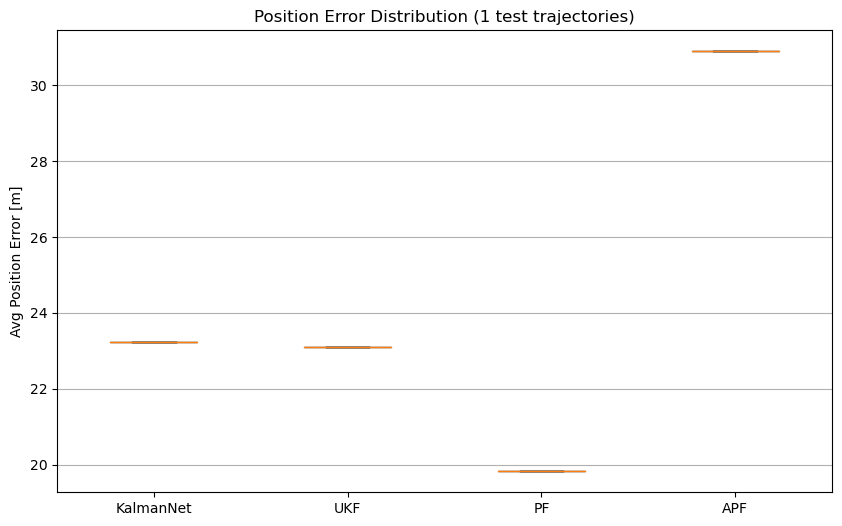

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Filters
import os
from tqdm import tqdm
from Filters import TAN

# === KONFIGURACE ===
TEST_DATA_PATH = './generated_data_synthetic_controlled/test_set/test.pt'
PLOT_PER_ITERATION = False  # Vykreslovat graf pro každou trajektorii?
MAX_TEST_SAMPLES = 5      # Kolik trajektorií z test setu vyhodnotit (max 10, co jsme vygenerovali)

print(f"=== VYHODNOCENÍ NA TESTOVACÍ SADĚ ===")
print(f"Načítám data z: {TEST_DATA_PATH}")

# 1. Načtení Testovací sady
if not os.path.exists(TEST_DATA_PATH):
    raise FileNotFoundError(f"Soubor {TEST_DATA_PATH} neexistuje! Spusťte generování testovací sady.")

test_data = torch.load(TEST_DATA_PATH, map_location=device)
X_test_all = test_data['x']  # Ground Truth [N, Seq, 4]
Y_test_all = test_data['y']  # Measurements [N, Seq, 3]

n_samples = min(X_test_all.shape[0], MAX_TEST_SAMPLES)
print(f"Počet testovacích trajektorií: {n_samples}")
print(f"Délka sekvence: {X_test_all.shape[1]}")
print("Modely: KalmanNet vs. UKF vs. PF")

# 2. Inicializace pro sběr dat
detailed_results = []
agg_mse = {"KNet": [], "UKF": [], "PF": [], "APF": []}
agg_pos = {"KNet": [], "UKF": [], "PF": [], "APF": []}

# Ujistíme se, že KNet je v eval módu
state_knet2.eval()

# --- HLAVNÍ SMYČKA (Iterace přes testovací trajektorie) ---
for i in tqdm(range(n_samples), desc="Evaluace"):
    
    # A) Příprava dat pro tento běh
    x_gt_tensor = X_test_all[i]      # [Seq, 4]
    y_obs_tensor = Y_test_all[i]     # [Seq, 3]
    
    x_gt = x_gt_tensor.cpu().numpy()
    seq_len = x_gt.shape[0]
    
    # Skutečný startovní stav (pro inicializaci filtrů)
    true_init_state = x_gt_tensor[0] # [4]
    
    # B) Inference: KalmanNet
    # KNet očekává [Batch, Seq, Dim], takže musíme přidat dimenzi
    with torch.no_grad():
        initial_state_batch = true_init_state.unsqueeze(0) # [1, 4]
        
        # Reset stavu sítě
        state_knet2.reset(batch_size=1, initial_state=initial_state_batch)
        
        knet_preds = []
        # KNet zpracovává sekvenci krok po kroku (nebo bychom mohli upravit forward na celou sekvenci)
        # Zde zachováme logiku step-by-step pro konzistenci
        
        # Vstup y_obs_tensor má tvar [Seq, 3]. Potřebujeme [1, 3] pro každý krok
        y_input_batch = y_obs_tensor.unsqueeze(0) # [1, Seq, 3]
        
        for t in range(1, seq_len):
            y_t = y_input_batch[:, t, :] # [1, 3]
            x_est = state_knet2.step(y_t)
            knet_preds.append(x_est)
            
        # Složení predikce (přidáme počáteční stav)
        if len(knet_preds) > 0:
            knet_preds_tensor = torch.stack(knet_preds, dim=1) # [1, Seq-1, 4]
            full_knet_est = torch.cat([initial_state_batch.unsqueeze(1), knet_preds_tensor], dim=1)
        else:
            full_knet_est = initial_state_batch.unsqueeze(1)
            
        x_est_knet = full_knet_est.squeeze().cpu().numpy()

    # C) Inference: UKF & PF
    # Filtry očekávají [Seq, Dim] (bez batch dimenze, pokud tak byly napsány)
    
    # UKF
    ukf_ideal = TAN.UnscentedKalmanFilterTAN(system_model)
    ukf_res = ukf_ideal.process_sequence(
        y_seq=y_obs_tensor,
        Ex0=true_init_state, 
        P0=system_model.P0
    )
    x_est_ukf = ukf_res['x_filtered'].cpu().numpy()

    # PF (Snížil jsem počet částic na 2000 pro rychlost, pro finální diplomku dejte více)
    pf = TAN.ParticleFilterTAN(system_model, num_particles=1000) 
    pf_res = pf.process_sequence(
        y_seq=y_obs_tensor,
        Ex0=true_init_state, 
        P0=system_model.P0
    )
    x_est_pf = pf_res['x_filtered'].cpu().numpy()

    # Auxiliary PF
    apf = TAN.AuxiliaryParticleFilterTAN(system_model, num_particles=200000) 
    apf_res = apf.process_sequence(
        y_seq=y_obs_tensor,
        Ex0=true_init_state, 
        P0=system_model.P0
    )
    x_est_apf = apf_res['x_filtered'].cpu().numpy()
    
    # D) Výpočet chyb
    # Ořežeme na délku min(odhad, gt) pro jistotu
    min_len = min(len(x_gt), len(x_est_knet), len(x_est_ukf))
    
    # KNet
    diff_knet = x_est_knet[:min_len] - x_gt[:min_len]
    mse_knet = np.mean(np.sum(diff_knet[:, :2]**2, axis=1)) # Pouze XY chyba
    pos_err_knet = np.mean(np.sqrt(diff_knet[:, 0]**2 + diff_knet[:, 1]**2))
    
    # UKF
    diff_ukf = x_est_ukf[:min_len] - x_gt[:min_len]
    mse_ukf = np.mean(np.sum(diff_ukf[:, :2]**2, axis=1))
    pos_err_ukf = np.mean(np.sqrt(diff_ukf[:, 0]**2 + diff_ukf[:, 1]**2))
    
    # PF
    diff_pf = x_est_pf[:min_len] - x_gt[:min_len]
    mse_pf = np.mean(np.sum(diff_pf[:, :2]**2, axis=1))
    pos_err_pf = np.mean(np.sqrt(diff_pf[:, 0]**2 + diff_pf[:, 1]**2))

    # APF
    diff_apf = x_est_apf[:min_len] - x_gt[:min_len]
    mse_apf = np.mean(np.sum(diff_apf[:, :2]**2, axis=1))
    pos_err_apf = np.mean(np.sqrt(diff_apf[:, 0]**2 + diff_apf[:, 1]**2))
    
    # Uložení
    agg_mse["KNet"].append(mse_knet)
    agg_pos["KNet"].append(pos_err_knet)
    agg_mse["UKF"].append(mse_ukf)
    agg_pos["UKF"].append(pos_err_ukf)
    agg_mse["PF"].append(mse_pf)
    agg_pos["PF"].append(pos_err_pf)
    agg_mse["APF"].append(mse_apf)
    agg_pos["APF"].append(pos_err_apf)

    detailed_results.append({
        "Run_ID": i + 1,
        "KNet_MSE": mse_knet,
        "UKF_MSE": mse_ukf,
        "PF_MSE": mse_pf,
        "KNet_PosErr": pos_err_knet,
        "UKF_PosErr": pos_err_ukf,
        "PF_PosErr": pos_err_pf,
        "APF_MSE": mse_apf,
        "APF_PosErr": pos_err_apf
    })
    
    # E) Vykreslení
    if PLOT_PER_ITERATION:
        fig = plt.figure(figsize=(12, 6))
        # Vykreslíme jen XY trajektorii
        plt.plot(x_gt[:, 0], x_gt[:, 1], 'k-', linewidth=3, alpha=0.3, label='Ground Truth')
        plt.plot(x_est_knet[:, 0], x_est_knet[:, 1], 'g-', linewidth=2, label=f'KalmanNet (Err: {pos_err_knet:.1f}m)')
        plt.plot(x_est_ukf[:, 0], x_est_ukf[:, 1], 'b--', linewidth=1, label=f'UKF (Err: {pos_err_ukf:.1f}m)')
        plt.plot(x_est_pf[:, 0], x_est_pf[:, 1], 'r:', linewidth=1, alpha=0.6, label=f'PF (Err: {pos_err_pf:.1f}m)')
        plt.plot(x_est_apf[:, 0], x_est_apf[:, 1], 'm-.', linewidth=1, alpha=0.6, label=f'APF (Err: {pos_err_apf:.1f}m)')
        plt.title(f"Test Trajectory {i+1} (Length {seq_len})")
        plt.xlabel("X [m]")
        plt.ylabel("Y [m]")
        plt.legend()
        plt.axis('equal')
        plt.grid(True)
        plt.show()

# --- VÝPIS VÝSLEDKŮ ---
df_results = pd.DataFrame(detailed_results)
print("\n" + "="*80)
print(f"DETAILNÍ VÝSLEDKY PO JEDNOTLIVÝCH TRAJEKTORIÍCH")
print("="*80)
pd.options.display.float_format = '{:,.2f}'.format
print(df_results[["Run_ID", "KNet_MSE", "UKF_MSE", "PF_MSE", "APF_MSE", "KNet_PosErr", "UKF_PosErr", "PF_PosErr", "APF_PosErr"]])

print("\n" + "="*80)
print(f"SOUHRNNÁ STATISTIKA ({n_samples} trajektorií)")
print("="*80)

def get_stats(key):
    return np.mean(agg_mse[key]), np.std(agg_mse[key]), np.mean(agg_pos[key]), np.std(agg_pos[key])

knet_stats = get_stats("KNet")
ukf_stats = get_stats("UKF")
pf_stats = get_stats("PF")
apf_stats = get_stats("APF")
print(f"{'Model':<15} | {'MSE (Mean ± Std)':<25} | {'Pos Error (Mean ± Std)':<25}")
print("-" * 75)
print(f"{'KalmanNet':<15} | {knet_stats[0]:.1f} ± {knet_stats[1]:.1f} | {knet_stats[2]:.2f} ± {knet_stats[3]:.2f} m")
print(f"{'UKF':<15} | {ukf_stats[0]:.1f} ± {ukf_stats[1]:.1f} | {ukf_stats[2]:.2f} ± {ukf_stats[3]:.2f} m")
print(f"{'PF':<15} | {pf_stats[0]:.1f} ± {pf_stats[1]:.1f} | {pf_stats[2]:.2f} ± {pf_stats[3]:.2f} m")
print(f"{'APF':<15} | {apf_stats[0]:.1f} ± {apf_stats[1]:.1f} | {apf_stats[2]:.2f} ± {apf_stats[3]:.2f} m")
print("="*80)

plt.figure(figsize=(10, 6))
plt.boxplot([agg_pos["KNet"], agg_pos["UKF"], agg_pos["PF"], agg_pos["APF"]], labels=['KalmanNet', 'UKF', 'PF', 'APF'], patch_artist=True)
plt.title(f"Position Error Distribution ({n_samples} test trajectories)")
plt.ylabel("Avg Position Error [m]")
plt.grid(True, axis='y')
plt.show()